# Parsing Wikipedia Articles

In this notebook, we are going to be parsing all of our downloaded wikipedia articles.
We'll get to make use of a number of important data science techniques including:
- Finding and retrieve online data
- Parsing XML using a SAX parser
- Parsing Mediawiki content using mwparserfromhell
- Running operations in parallel using multiprocessing and multithreading


In [1]:
import requests
from bs4 import BeautifulSoup
import os

## Searching for Wikipedia Download

In [2]:
base_url = 'https://dumps.wikimedia.org/enwiki/'
index = requests.get(base_url).text
soup_index = BeautifulSoup(index, 'html.parser')

dumps = [a['href'] for a in soup_index.find_all('a') if 
         a.has_attr('href')]
dumps

['../',
 '20240601/',
 '20240620/',
 '20240701/',
 '20240720/',
 '20240801/',
 '20240820/',
 '20240901/',
 'latest/']

#### This line of code finds the html content of the page for the dump made on the first of August.

In [3]:
dump_url = base_url + '20240801/'

dump_html = requests.get(dump_url).text
dump_html[:10]

'<!DOCTYPE '

To find all the individual files, we'll search through the html from the dump identified earlier. We'll look for any files that have **pages_articles** in the text. To parse through html (or other markup languages), we can use Beautiful Soup. This makes searching for particular tags and classes very efficient.

In [4]:
soup_dump = BeautifulSoup(dump_html, 'html.parser')

soup_dump.find_all('li', {'class': 'file'}, limit = 10)[:4]

[<li class="file"><a href="/enwiki/20240801/enwiki-20240801-pages-articles-multistream.xml.bz2">enwiki-20240801-pages-articles-multistream.xml.bz2</a> 22.2 GB</li>,
 <li class="file"><a href="/enwiki/20240801/enwiki-20240801-pages-articles-multistream-index.txt.bz2">enwiki-20240801-pages-articles-multistream-index.txt.bz2</a> 250.1 MB</li>,
 <li class="file"><a href="/enwiki/20240801/enwiki-20240801-pages-articles-multistream1.xml-p1p41242.bz2">enwiki-20240801-pages-articles-multistream1.xml-p1p41242.bz2</a> 269.7 MB</li>,
 <li class="file"><a href="/enwiki/20240801/enwiki-20240801-pages-articles-multistream-index1.txt-p1p41242.bz2">enwiki-20240801-pages-articles-multistream-index1.txt-p1p41242.bz2</a> 221 KB</li>]

In [5]:
files = []

for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    if 'pages-articles' in text:
        files.append((text.split()[0], text.split()[1:]))
        
files[:5]

[('enwiki-20240801-pages-articles-multistream.xml.bz2', ['22.2', 'GB']),
 ('enwiki-20240801-pages-articles-multistream-index.txt.bz2', ['250.1', 'MB']),
 ('enwiki-20240801-pages-articles-multistream1.xml-p1p41242.bz2',
  ['269.7', 'MB']),
 ('enwiki-20240801-pages-articles-multistream-index1.txt-p1p41242.bz2',
  ['221', 'KB']),
 ('enwiki-20240801-pages-articles-multistream2.xml-p41243p151573.bz2',
  ['360.0', 'MB'])]

In [6]:
files_to_download = [file[0] for file in files if '.xml-p' in file[0]]
files_to_download[-5:]

['enwiki-20240801-pages-articles27.xml-p71475910p72975909.bz2',
 'enwiki-20240801-pages-articles27.xml-p72975910p74475909.bz2',
 'enwiki-20240801-pages-articles27.xml-p74475910p75975909.bz2',
 'enwiki-20240801-pages-articles27.xml-p75975910p77475909.bz2',
 'enwiki-20240801-pages-articles27.xml-p77475910p77508831.bz2']

In [7]:
import sys
from keras.utils import get_file

keras_home = 'C:/Users/Mosses Ogbonna/.keras/datasets/'

In [8]:
data_paths = []
file_info = []

# Iterate through each file
for file in files_to_download:
    path = keras_home + file
    
    # Check to see if the path exists (if the file is already downloaded)
    if not os.path.exists(keras_home + file):
        print('Downloading')
        # If not, download the file
        data_paths.append(get_file(file, dump_url))
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
        
    # If the file is already downloaded find some information
    else:
        data_paths.append(path)
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_number = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file.split('-')[-1], file_size, file_number))

What is the largest file? We can use **sorted** to sort by the file size.

In [9]:
sorted(file_info, key = lambda x: x[1], reverse = True)[:5]

[('p2936261p4045402.bz2', 594.896354, 1109141),
 ('p4045403p5399366.bz2', 587.651257, 1353963),
 ('p2936261p4045402.bz2', 577.74861, 1109141),
 ('p5399367p6899366.bz2', 568.854935, 1499999),
 ('p4045403p5399366.bz2', 567.40116, 1353963)]

    These sizes are in MB. It looks like the largest files are about 590 MB compressed

In [10]:
sorted(file_info, key = lambda x: x[2], reverse = True)[:5]

[('p5399367p6899366.bz2', 568.854935, 1499999),
 ('p7054860p8554859.bz2', 471.801854, 1499999),
 ('p9172789p10672788.bz2', 384.774608, 1499999),
 ('p11659683p13159682.bz2', 465.007963, 1499999),
 ('p14324603p15824602.bz2', 414.28953, 1499999)]

In [11]:
print(f'There are {len(file_info)} partitions.')

There are 134 partitions.


#### We can put this info into a dataframe to plot the file sizes.

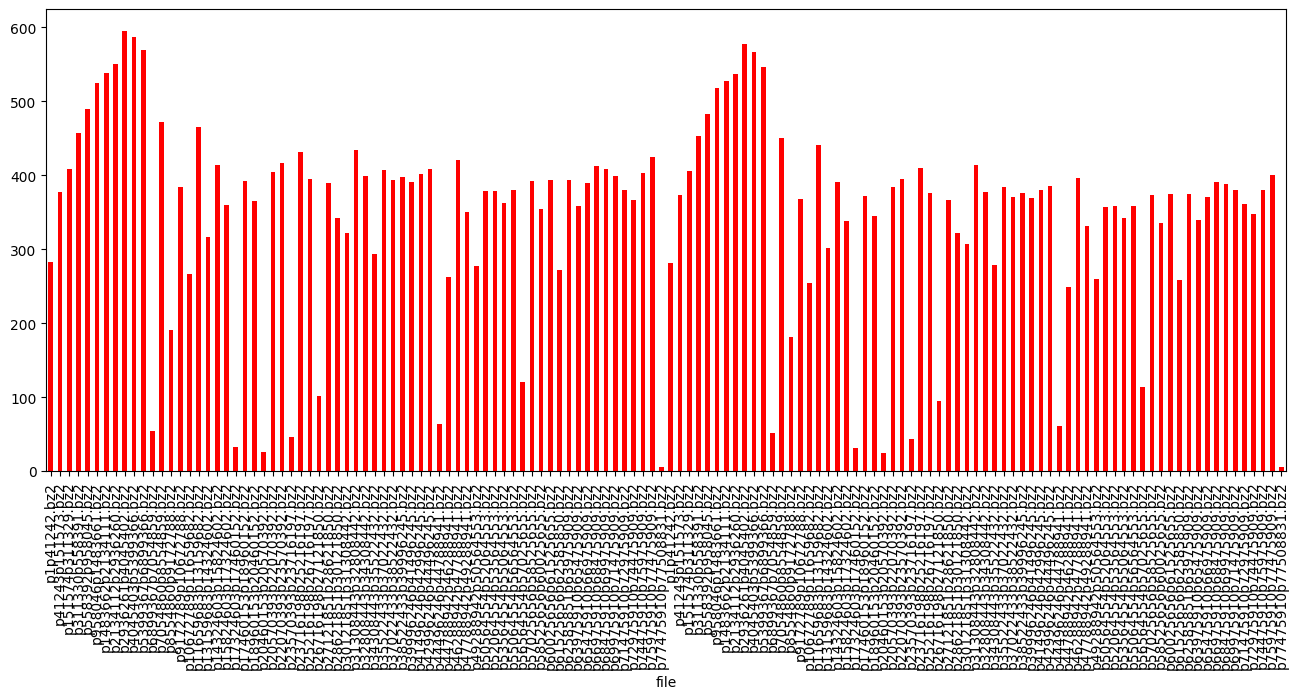

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color = 'red', figsize = (16, 6));

In [13]:
print(f"The total size of files on disk is {file_df['size (MB)'].sum() / 1e3} GB")

The total size of files on disk is 46.619997688999995 GB


### Parsing the Data

Together, the files take up 46.6 GB. Decompressed as xml, it's over to 100 GB. We could decompress each file into XML and then parse through it, but we can also parse through a decompressed file iteratively one line at a time. If we are concered about disk space, this is a better option. Working through the compressed file one line at a time also might be the only option in cases where the individual files are too large to fit in memory.

In [14]:
import bz2
import subprocess

data_path = data_paths[80]
data_path

'C:/Users/Mosses Ogbonna/.keras/datasets/enwiki-20240801-pages-articles12.xml-p8554860p9172788.bz2'

#### Let's see what kind of data we have

In [15]:
lines = []

for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    lines.append(line)
    if i > 5e5:
        break
        
lines[-142:-23]

[b'  <page>\n',
 b'    <title>Stony Plain Eagles</title>\n',
 b'    <ns>0</ns>\n',
 b'    <id>8583056</id>\n',
 b'    <revision>\n',
 b'      <id>1221022323</id>\n',
 b'      <parentid>1221022295</parentid>\n',
 b'      <timestamp>2024-04-27T10:51:02Z</timestamp>\n',
 b'      <contributor>\n',
 b'        <username>Oilerator</username>\n',
 b'        <id>31851650</id>\n',
 b'      </contributor>\n',
 b'      <minor />\n',
 b'      <origin>1221022323</origin>\n',
 b'      <model>wikitext</model>\n',
 b'      <format>text/x-wiki</format>\n',
 b'      <text bytes="6023" sha1="cuj41hiqwx8931pkfj5x6bm2r6os9oh" xml:space="preserve">{{Cleanup bare URLs|date=August 2022}}\n',
 b'{{Infobox Pro hockey team\n',
 b'| current     = \n',
 b'| team        = Stony Plain Eagles\n',
 b'| logo        = Stony Plain Eagles logo.png\n',
 b'| logosize    = 220px\n',
 b'| city        = [[Stony Plain, Alberta]], Canada\n',
 b'| league      = [[Chinook Hockey League]]\n',
 b'| conference  = \n',
 b'| division   

    Here we have a complete article. We could go through each file and extract out the articles using regular expressions, but that would be extremely inefficient. Instead, we'll use an XML parser to find the article text that we then will use another parser to extract information from.

## Parsing Approach

In order to get useful information from this data, we have to parse it on two levels.
1. Extract the titles and article text from the XML
2. Extract relevant information from the article text


In [16]:
import xml.sax

class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Content handler for Wiki XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._pages.append((self._values['title'], self._values['text']))

    The Content handler looks for certain start tags, and when it finds one, it adds characters to the buffer until it encouters the same end tag. Then it saves the buffer content to a dictionary with the tag as key. We are overriding a few of the default SAX ContentHandler methods in order to do what we want: find the titles and texts in the XML.

    The text of Wikipedia articles starts and ends with the <text> tag and the entire article starts and ends with the <page> tag. The <timestamp> tag records the last edit of the page.

Next, we need to create a **handler** object of the **WikiXMLHandler** class. Then we pass the handler in as the content handler to a **SAX** parser.

In [17]:
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

handler._pages

[]

Let's work through a single article. We **feed** in one line of XML at a time to the **parser**. It searches the XML for the tags using the methods in the handler. The correct data is then stored in the handler (later we'll pass the **text** on to another parser).

In [18]:
for l in lines[-142:-23]:
    parser.feed(l)

In [19]:
handler._pages

[('Stony Plain Eagles',
  '{{Cleanup bare URLs|date=August 2022}} \n {{Infobox Pro hockey team \n | current     =  \n | team        = Stony Plain Eagles \n | logo        = Stony Plain Eagles logo.png \n | logosize    = 220px \n | city        = [[Stony Plain, Alberta]], Canada \n | league      = [[Chinook Hockey League]] \n | conference  =  \n | division    =  \n | founded     = 1930s \n | operated    =  \n | arena       = Glenn Hall Centennial Arena \n | colours     = Blue, white, yellow < br / > {{Color box|#05143f|border=darkgray}} {{Color box|#feba35|border=darkgray}} {{Color box|white|border=darkgray}} \n | owner       = Silent Ice Sports  &  Entertainment < ref name= " SILENTICE " > {{cite web | url=https://www.silentice.com/content/about | title=About | publisher=Silent Ice Sports  &  Entertainment | date= | access-date=2022-05-23}} < /ref > \n | GM          = \n | coach       =  \n | captain     =  \n | affiliates  =  \n | parentclub  =  \n | farmclub    =  \n | website     = [h

    We have successfully extracted one page! Once we have the page text, we need to process it as well to find the information we want. We'll write that function next. First, let's see this process again, this time finding three different articles.

In [20]:
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    parser.feed(line)
    
    if len(handler._pages) > 2:
        break
        
print([x[0] for x in handler._pages])

['Chestnut Ridge Middle School', 'Colegio de Santa Cruz de Tlatelolco', 'Template:US-gov-bio-stub']


## Parsing Articles

The text of the articles themselves is processed using the **mwparserfromhell**. Although the text may simple look like a Python string, there is far more information contained in the formatting of the **text** than just the information we can see.

First we'll find a number of articles using the **WikiXmlHandler** and a SAX parser.

In [21]:
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    parser.feed(line)
    
    # Stop when 50 articles have been found
    if len(handler._pages) > 50:
        break

#### To create a **wiki** representation of the text, we pass the Wikipedia article text to the **mwparserfromhell**.

In [22]:
import mwparserfromhell 

print(handler._pages[6][0])

wiki = mwparserfromhell.parse(handler._pages[6][1])

Shuo Wang


In [23]:
print(type(wiki))
wiki[:100]

<class 'mwparserfromhell.wikicode.Wikicode'>


'#REDIRECT [[Wang Shuo]]'

In [24]:
wikilinks = [x.title for x in wiki.filter_wikilinks()]
print(f'There are {len(wikilinks)} wikilinks.')
wikilinks[:5]

There are 1 wikilinks.


['Wang Shuo']

In [25]:
wiki.filter_arguments()

[]

In [26]:
wiki.filter_comments()

[]

    To figure out everything you can do with mwparserfromhell, read the docs: https://mwparserfromhell.readthedocs.io/en/latest/

In [27]:
external_links = [(x.title, x.url) for x in wiki.filter_external_links()]
print(f'There are {len(external_links)} external links.')
external_links[:5]

There are 0 external links.


[]

In [28]:
wiki.strip_code().strip()[:100]

'REDIRECT Wang Shuo'

In [29]:
import re

def process_article(title, text, timestamp, template = 'Infobox book'):
    
    wikicode = mwparserfromhell.parse(text)
    
    matches = wikicode.filter_templates(matches = template)
    
    matches = [x for x in matches if x.name.strip_code().strip().lower() == template.lower()]
    
    if len(matches) >= 1:

        properties = {param.name.strip_code().strip(): param.value.strip_code().strip() 
                      for param in matches[0].params
                      if param.value.strip_code().strip()}

        wikilinks = [x.title.strip_code().strip() for x in wikicode.filter_wikilinks()]

        exlinks = [x.url.strip_code().strip() for x in wikicode.filter_external_links()]

        text_length = len(wikicode.strip_code().strip())

        return (title, properties, wikilinks, exlinks, timestamp, text_length)

### Modified Content Handler

To parse the text from each article and search for the specified template, we slightly modify the **Handler** class. This time, in the **endElement** function, if the article ends (the tag is **page**) then we send the title and the contents (**text**) to the **process_article** function. This function will return either nothing if it doesn't find a book, or the book properties, Wikilinks, and external links if it does find a book. These will be added as a list to the **handler**.

In [30]:
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._books = []
        self._article_count = 0
        self._non_matches = []

    def characters(self, content):
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        if name in ('title', 'text', 'timestamp'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._article_count += 1
            book = process_article(**self._values, template = 'Infobox book')
            if book:
                self._books.append(book)

To use this for a different category of articles on Wikipedia, all you need to do is change the template. You can also alter the **process_article** function if you want to return different information for each article.

Now let's see if this works. The code below stops when we've found 3 books.

In [31]:
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._books) > 2:
        break
        
print(f'Searched through {handler._article_count} articles to find 3 books.')

Searched through 1546 articles to find 3 books.


In [32]:
handler._books[0]

('Celsius 7/7',
 {'italic title': '< !--(see above)-- >',
  'name': 'Celsius 7/7',
  'image': 'Celsius 7-7.jpg',
  'image_size': '250px',
  'author': 'Michael Gove',
  'country': 'United Kingdom',
  'language': 'English',
  'subject': 'Islamic terrorism',
  'publisher': 'Weidenfeld  &  Nicolson',
  'published': 'June 29, 2006',
  'pages': '153',
  'isbn': '0-297-85146-2'},
 ['Michael Gove',
  'Islamic terrorism',
  'Weidenfeld  &  Nicolson',
  'Conservative Party (UK)',
  'Michael Gove',
  'Islamic terrorism',
  'Weidenfeld  &  Nicolson',
  'Orion Publishing Group',
  'Islamism',
  'Nazism',
  'Communism',
  'Michael Gove',
  'Andrew Pierce',
  'The Daily Telegraph',
  "Her Majesty's Government",
  'The Times Literary Supplement',
  'Literary Review',
  'Walter Laqueur',
  'Michael Burleigh',
  'Damian Thompson',
  'The Daily Telegraph',
  'Manichaean#Figurative use',
  'William Dalrymple (historian)',
  'Melanie Phillips',
  'Stephen Pollard',
  'Fahrenheit 9/11',
  'Islamophobia in t

In [33]:
import os
import bz2

input_path = 'C:/Users/Mosses Ogbonna/.keras/datasets/enwiki-20240801-pages-articles12.xml-p8554860p9172788.bz2'
output_path = 'C:/Users/Mosses Ogbonna/.keras/datasets/p12.xml'

if not os.path.exists(output_path):
    with bz2.BZ2File(input_path, 'rb') as input_file, open(output_path, 'wb') as output_file:
        output_file.write(input_file.read())
    print('Decompressed successfully')
else:
    print('Already uncompressed')

Already uncompressed


In [34]:
from timeit import default_timer as timer

start = timer()
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    if (i + 1) % 10000 == 0:
        print(f'Processed {i + 1} lines so far.', end = '\r')
    try:
        parser.feed(line)
    except StopIteration:
        break
    
end = timer()
books = handler._books

print(f'\nSearched through {handler._article_count} articles.')
print(f'\nFound {len(books)} books in {round(end - start)} seconds.')

Processed 10780000 lines so far.
Searched through 167757 articles.

Found 725 books in 667 seconds.


### Writing to File

The best way to save the information is as **ndjson**. We can save and then load back in the books using the **json** library.

In [35]:
import json

with open('C:/Users/Mosses Ogbonna/Documents/data/p12_books.ndjson', 'wt') as fout:
    for l in books:
        fout.write(json.dumps(l) + '\n')

In [36]:
books_in = []

with open('C:/Users/Mosses Ogbonna/Documents/data/p12_books.ndjson', 'rt') as fin:
    for l in fin.readlines():
        books_in.append(json.loads(l))

In [37]:
books_in[10]

['Shadow Moon',
 {'1': '< !-- See Wikipedia:WikiProject Novels or Wikipedia:WikiProject Books -- >',
  'name': 'Shadow Moon',
  'image': 'Shadow Moon (novel).jpg',
  'author': 'Chris Claremont, George Lucas',
  'cover_artist': 'Ciruelo Cabral',
  'country': 'United States',
  'language': 'English',
  'series': 'Chronicles of the Shadow War',
  'genre': 'Fantasy literature',
  'published': '1995 (Bantam Spectra)',
  'media_type': 'Print (Hardback  &  Paperback)',
  'pages': '464',
  'isbn': '0-553-57285-7',
  'dewey': '813.54',
  'congress': 'PS3562 .U234',
  'oclc': '35177828',
  'followed_by': 'Shadow Dawn'},
 ['Wikipedia:WikiProject Novels',
  'Wikipedia:WikiProject Books',
  'Chris Claremont',
  'George Lucas',
  'Ciruelo Cabral',
  'United States',
  'Chronicles of the Shadow War',
  'Fantasy literature',
  'Bantam Spectra',
  'Hardcover',
  'Paperback',
  'Shadow Dawn',
  'Chris Claremont',
  'George Lucas',
  'Goodreads',
  'Willow (1988 film)',
  'Chronicles of the Shadow War',


In [38]:
import gc
import json

def find_books(data_path, limit = None, save = True):
    handler = WikiXmlHandler()

    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)

    for i, line in enumerate(bz2.BZ2File(data_path, 'r')):

        try:
            parser.feed(line)
        except StopIteration:
            break
            
        # Optional limit
        if limit is not None and len(handler._books) >= limit:
            return handler._books
    
    if save:
        partition_dir = 'C:/Users/Mosses Ogbonna/Documents/data/wiki/partitions/'
        p_str = data_path.split('-')[-1].split('.')[-2]
        out_dir = partition_dir + f'{p_str}.ndjson'

        with open(out_dir, 'w') as fout:
            # Write as json
            for book in handler._books:
                fout.write(json.dumps(book) + '\n')
        
        print(f'{len(os.listdir(partition_dir))} files processed.', end = '\r')

    # Memory management
    del handler
    del parser
    gc.collect()
    return None

**Now we use the function to search for every book article**

In [ ]:
for i in range(len(data_paths)):
    find_books(data_paths[i])

    This took about 40 hours. But this is a naive approach and also not taking full advantage of our resources. Instead, we can use either multithreading or multiprocessing to parse many files at the same time, greatly speeding up the overall process.

### Join Data Together

After creating the separate files, each one containing the books from one partition, we can join them together into a single list by reading them from disk. For this task, we'll use **multithreading** to read in the files in parallel. Again, we'll need a service, this time the function **read_data**, and tasks, all the **saved_files**, each of which contains the books for one partition.

In [39]:
def read_data(file_path):
    
    data = []
    
    # Open the file and load in json
    with open(file_path, 'r') as fin:
        for l in fin.readlines():
            data.append(json.loads(l))
            
    return data

In [40]:
from multiprocessing.dummy import Pool as Threadpool
from itertools import chain

start = timer()

# List of files to read in
saved_files = ['C:/Users/Mosses Ogbonna/Documents/data/wiki/partitions/' + x for x in os.listdir('C:/Users/Mosses Ogbonna/Documents/data/wiki/partitions/')]   

# Create a threadpool for reading in files
threadpool = Threadpool(processes = 10)

# Read in the files as a list of lists
results = threadpool.map(read_data, saved_files)

# Flatten the list of lists to a single list
book_list = list(chain(*results))

end = timer()

print(f'Found {len(book_list)} books in {round(end - start)} seconds.')

Found 48148 books in 2 seconds.


#### The code below saves all the books as a single file.

In [41]:
if not os.path.exists(os.getcwd() + 'C:/Users/Mosses Ogbonna/Documents/data/found_books_filtered.ndjson'):
    with open('C:/Users/Mosses Ogbonna/Documents/data/found_books_filtered.ndjson', 'wt') as fout:
        for book in book_list:
             fout.write(json.dumps(book) + '\n')
    print('Books saved.')
else:
    print('Files already saved.')

Books saved.


 We searched through over 100 GB of total files to find 85 MB worth of books.

### Conclusions
Having information is only useful if we can make sense of it, so we also thoroughly covered how to parse through the data. The end result is code that can be used to find and extract any information from any category of article on Wikipedia. Along the way, we covered a number of critical data science skills:

- Parsing HTML using BeautifulSoup
- Parsing XML using SAX
- Parsing Mediawiki using mwparserfromhell
- Benchmarking different ways to solve a problem for efficiency comparisons

Wikipedia is a rich source of information and quite an achievement of modern humanity. After completing this project, we know how to access and make use of all this information.